# Part 2: Data Exercise

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity#


In [2]:

# Load the dataset
data = pd.read_excel("cps09mar-1.xlsx")
data.columns

Index(['age', 'female', 'hisp', 'education', 'earnings', 'hours', 'week',
       'union', 'uncov', 'region', 'race', 'marital'],
      dtype='object')

In [3]:

# Filter the subsample
data['experience'] = data['age'] - data['education'] - 6
data['log_wage'] = np.log(data['earnings']/data['hours'])
subset = data[(data['education'] == 20) & (data['experience'] >= 0) & (data['experience'] <= 40)]


In [4]:

# Separate by gender
men = subset[subset['female'] == 0]
women = subset[subset['female'] == 1]


## A.
Use Nadaraya-Watson to estimate the regression of log(wage) on experience, separately for men and women. Plot with 95% confidence intervals. Comment on how the estimated wage profiles vary with experience. In particular, do you think the evidence suggests that expected wages fall for experience levels above 20 for this education group?

In [5]:
# Define the Epanechnikov kernel function with u^2 term for integration
from scipy.integrate import quad
def epanechnikov_kernel(u):
      # Verificar valores de u antes de la operación
    result = np.where(np.abs(u) <= np.sqrt(5), (3 / (4 * np.sqrt(5))) * (1 - (u**2) / 5), 0)
    # Verificar el resultado de la operación
    return result

    
def epanechnikov_kappa2():
    def integrand(u):
        return epanechnikov_kernel(u)**2
    kappa2, _ = quad(integrand, -np.sqrt(5), np.sqrt(5))
    return kappa2

# Compute kappa_2 by integrating u^2 * K(u) over the range -sqrt(5) to sqrt(5)
kappa_2 = epanechnikov_kappa2()

def gausian_kernel(u):
    normal =  (1 / (np.sqrt(2 * np.pi))) * np.exp(-((u)**2)/(2))
    return normal

In [6]:
def kernel_func(u,kernel):
    if kernel == 'epanechnikov':
        return epanechnikov_kernel(u)
    elif kernel == 'gaussian':
        return gausian_kernel(u)
    else:
        raise ValueError("Unsupported kernel")

In [7]:

# Function for Nadaraya-Watson estimator
def nadaraya_watson(X, Y, x_grid, bandwidth, kernel='epanechnikov'):
    #X is the point of x to estimate
    #Y is the point of y to estimate, at the same point of x
    #x_grid is the grid of x values to estimate (Can be the number of values in the data too, like the whole X)
    estimates = []
    for x in x_grid:
        weights = kernel_func((X - x) / bandwidth, kernel) 
        #the weights are the kernel function evaluated at the distance between the point to estimate and the point of the data
        numerator = np.sum(weights * Y)
        denominator = np.sum(weights)
        estimates.append(numerator / denominator if denominator > 0 else 0)
    return np.array(estimates)


In [8]:
def local_linear_estimator(X, Y, x_eval, bandwidth, kernel='epanechnikov'):
    # Create the design matrix U(x)
    n = len(X)
    U = np.vstack([np.ones(n), X - x_eval]).T
    
    W = np.diag(kernel_func((X - x_eval) / bandwidth, kernel)) / bandwidth


    # Solve for theta_hat using the closed-form solution
    theta_hat = np.linalg.inv(U.T @ W @ U) @ (U.T @ W @ Y)
    
    # Return the fitted value at x_eval (theta_0 + theta_1 * 0)
    return theta_hat[0], theta_hat[1]

In [9]:
def loocv_bandwidth(X, Y, bandwidth_range, kernel='epanechnikov', estimator='local_linear'):
    best_bandwidth = None
    best_cv_score = float('inf')
#Leave one out cross validation
#Here, X is the data, Y is the target, bandwidth_range is the range of bandwidths to test, kernel is the kernel to use, and estimator is the estimator to use.
    for h in bandwidth_range:
        cv_score = 0
        n = len(X)
        residual = []
        for i in range(n):  # Leave-One-Out logic
            # Exclude the i-th observation
            X_loo = np.delete(X, i)
            Y_loo = np.delete(Y, i)

            # Compute weights and predictions based on the estimator
            if estimator == 'local_linear':
                # Local Linear Estimator
                pre = local_linear_estimator(X_loo, Y_loo, X[i], h, kernel)
                #here, prediction is the prediction at the point X[i]
                predictions = pre[0] 

            elif estimator == 'nadaraya_watson':
                # Nadaraya-Watson Estimator
                weights = kernel_func((X_loo - X[i]) / h, kernel)
                #here, weights are the kernel function evaluated at the distance between the point to estimate and the point of the data excluding the point to estimate
                numerator = np.sum(weights * Y_loo)
                denominator = np.sum(weights)
                predictions = numerator / denominator if denominator > 0 else 0
                #here, predictions is the prediction at the point X[i]
            else:
                raise ValueError("Unsupported estimator. Use 'local_linear' or 'nadaraya_watson'.")

            # Accumulate squared error for the LOO-CV score
            cv_score += (Y[i] - predictions)**2
            residual.append(Y[i] - predictions)

        # Average the CV score
        cv_score /= n
        
        # Update the best bandwidth
        if cv_score < best_cv_score:
            best_cv_score = cv_score
            best_bandwidth = h
            best_residual = np.array(residual)
    return best_bandwidth,best_residual


In [10]:
#lets calculate log earnings

# Parameters
bandwidth_range_nw = np.linspace(1, 6, 5)  # Range for NW estimator
bandwidth_range_ll = np.linspace(3, 8, 5)  # Range for Local Linear estimator

# Process men and women
results = {}
x_grid = {}
for gender, group in [('Men', men), ('Women', women)]:
    X = group['experience'].values
    Y = group['log_wage'].values
    x_grid[gender] = np.linspace(X.min(), X.max(), num=100)
    # Optimal bandwidths
    optimal_bandwidth_nw,nw_residuals = loocv_bandwidth(X, Y, bandwidth_range_nw, kernel='epanechnikov', estimator='nadaraya_watson')
    optimal_bandwidth_ll,ll_residuals = loocv_bandwidth(X, Y, bandwidth_range_ll, kernel='epanechnikov', estimator='local_linear')
    print(optimal_bandwidth_nw)
    print(optimal_bandwidth_ll)
    # Estimates
    nw_estimates = nadaraya_watson(X, Y, x_grid[gender], optimal_bandwidth_nw, kernel='epanechnikov')
    ll_intercepts = []
    ll_slopes = []
    for x in x_grid[gender]:
        intercept, slope = local_linear_estimator(X, Y, x, optimal_bandwidth_ll, kernel='epanechnikov')
        ll_intercepts.append(intercept)
        ll_slopes.append(slope)
    
    results[gender] = {
        'optimal_bandwidth_nw': optimal_bandwidth_nw,
        'optimal_bandwidth_ll': optimal_bandwidth_ll,
        'nw_estimates': nw_estimates,
        'll_intercepts': ll_intercepts,
        'll_slopes': ll_slopes,
        'nw_residuals': nw_residuals,
        'll_residuals': ll_residuals
    }

2.25
4.25
3.5
5.5


In [11]:
def compute_s_hat(X, residuals, x_eval, bandwidth, kernel = 'epanechnikov'):
    # Kernel weights
    weights = kernel_func((X - x_eval) / bandwidth,kernel)
    
    weights_squared = (weights/bandwidth) ** 2
    residuals_squared = residuals ** 2
    
    # Kernel density estimate
    f_hat = np.sum(weights) / (len(X) * bandwidth)
    
    # Compute s_hat(x)
    s_hat = np.sqrt(np.sum(weights_squared * residuals_squared) / (len(X)**2 * f_hat**2))
    return s_hat
    

In [12]:
import scipy.stats as stats


def pointwise_confidence_interval(results,x_grid, kernel, alpha=0.05,gender='Men',estimator = "nadaraya_watson"):
    
    
    if estimator == "nadaraya_watson":
        res_type = "nw_residuals"
        estimate = 'nw_estimates'
        bandwidth = results[gender]['optimal_bandwidth_nw']
    else:
        res_type = 'll_residuals'
        estimate = 'll_intercepts'
        bandwidth = results[gender]['optimal_bandwidth_ll']
    if gender == 'Men':
        group = men
    else:
        group = women
    X = group['experience'].values
    # Compute residuals
    residuals = results[gender][res_type]
    m_hat = results[gender][estimate]
    # Compute s_hat(x)
      # Compute confidence intervals for each x in x_grid
    lower_bounds = []
    upper_bounds = []
    s_hat_1 = []
    for x_eval, m_eval in zip(x_grid, m_hat):
        s_hat = compute_s_hat(X, residuals, x_eval, bandwidth, kernel)
        z = stats.norm.ppf(1 - alpha / 2)
        s_hat_1.append(s_hat)
        lower_bounds.append(m_eval - z * s_hat)
        upper_bounds.append(m_eval + z * s_hat)
    
    return np.array(lower_bounds), np.array(upper_bounds),np.array(s_hat_1)


In [13]:
def sample_gaussian_xi(n):
    return np.random.normal(0, 1, size=n)
def compute_G(x_grid, X, residuals, bandwidth, kernel):
    n = len(X)
    G_values = []
    for x_eval in x_grid:
        # Kernel weights
        kernel_values = kernel_func((X - x_eval) / bandwidth, kernel)/bandwidth
        total_weight = np.sum(kernel_values)  # Normalize the weights
        weights = kernel_values / total_weight if total_weight > 0 else np.zeros_like(kernel_values)
            # Compute G(x, xi)
        xi = sample_gaussian_xi(n)
        s_hat = compute_s_hat(X, residuals, x_eval, bandwidth, kernel)
        G_x = np.sum(xi * residuals * weights / s_hat)
        G_values.append(G_x)
    
    return np.array(G_values)


In [14]:
def gaussian_multiplier_bootstrap(x_grid, X, residuals, bandwidth, kernel, B=1000, alpha=0.05):
    n = len(X)
    bootstrap_sup = []
    
    for _ in range(B):
        # Compute G(x, xi) for each x in x_grid
        G_values = compute_G(x_grid, X, residuals,bandwidth, kernel)
        
        # Take the supremum over x_grid
        bootstrap_sup.append(np.max(np.abs(G_values)))
    
    # Return the (1-alpha) quantile of the bootstrap distribution
    return np.quantile(bootstrap_sup, 1 - alpha)


In [15]:
def uniform_confidence_band(x_grid, X, m_hat, residuals, s_hat, bandwidth, kernel, B=1000, alpha=0.05):
    # Bootstrap quantile
    q_alpha = gaussian_multiplier_bootstrap(x_grid, X, residuals, bandwidth, kernel, B, alpha)
    
    # Compute confidence bands
    lower_bound = m_hat - s_hat * q_alpha
    upper_bound = m_hat + s_hat * q_alpha
    
    return lower_bound, upper_bound


In [16]:
# Store results for Men and Women
confidence_results = {}

for gender, group in [('Men', men), ('Women', women)]:
    X = group['experience'].values
    Y = group['log_wage'].values
    bandwidth = results[gender]['optimal_bandwidth_nw']
    m_hat = results[gender]['nw_estimates']
    residuals = results[gender]['nw_residuals']
    
    # Pointwise confidence intervals
    lower_bounds, upper_bounds, s_hat_values = pointwise_confidence_interval(
        results=results,
        x_grid=x_grid[gender],
        kernel='epanechnikov',
        gender=gender,
        estimator='nadaraya_watson'
    )
    
    # Uniform confidence intervals
    lower_bound_u, upper_bound_u = uniform_confidence_band(
        x_grid=x_grid[gender],
        X=X,
        m_hat=m_hat,
        residuals=residuals,
        s_hat=s_hat_values,
        bandwidth=bandwidth,
        kernel='epanechnikov',
        B=1000,
        alpha=0.05
    )
    
    # Store results
    confidence_results[gender] = {
        'm_hat': m_hat,
        'lower_bounds': lower_bounds,
        'upper_bounds': upper_bounds,
        'lower_bound_u': lower_bound_u,
        'upper_bound_u': upper_bound_u
    }


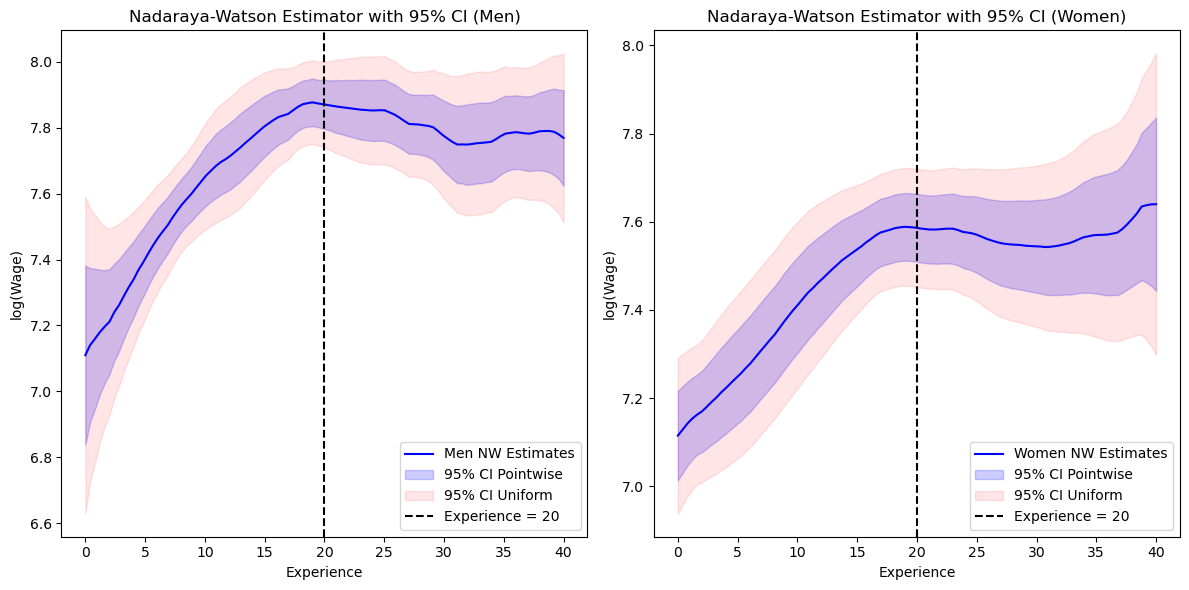

In [17]:
plt.figure(figsize=(12, 6))

for i, (gender, conf_res) in enumerate(confidence_results.items(), 1):
    plt.subplot(1, 2, i)
    
    # Plot Nadaraya-Watson estimates
    plt.plot(x_grid[gender], conf_res['m_hat'], label=f'{gender} NW Estimates', color='blue')
    
    # Pointwise confidence intervals
    plt.fill_between(x_grid[gender], conf_res['lower_bounds'], conf_res['upper_bounds'], 
                     color='blue', alpha=0.2, label='95% CI Pointwise')
    
    # Uniform confidence intervals
    plt.fill_between(x_grid[gender], conf_res['lower_bound_u'], conf_res['upper_bound_u'], 
                     color='red', alpha=0.1, label='95% CI Uniform')
    #lets add a vertical line for when experience is 20
    plt.axvline(x=20, color='black', linestyle='--', label='Experience = 20')
    
    # Plot settings
    plt.title(f'Nadaraya-Watson Estimator with 95% CI ({gender})')
    plt.xlabel('Experience')
    plt.ylabel('log(Wage)')
    plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


The wage profile shows a positive relationship between experience and log(wage) up to 20 years, after which it flattens, suggesting diminishing returns to additional experience. This trend is specific to individuals with a professional degree or doctorate, and profiles for other education groups, like high school graduates, may differ. Confidence intervals are narrower at lower experience levels due to denser data and widen at higher levels, reflecting greater uncertainty.

## B)
Repeat using the Local Linear estimator. How do the estimates and confidence intervals change?

In [18]:
# Store results for Men and Women
comparison_results = {}

for gender, group in [('Men', men), ('Women', women)]:
    X = group['experience'].values
    Y = group['log_wage'].values
    x_vals = x_grid[gender]
    
    # Nadaraya-Watson estimates
    nw_bandwidth = results[gender]['optimal_bandwidth_nw']
    nw_m_hat = results[gender]['nw_estimates']
    nw_residuals = results[gender]['nw_residuals']
    
    nw_lower_bounds, nw_upper_bounds, nw_s_hat = pointwise_confidence_interval(
        results=results, x_grid=x_vals, kernel='epanechnikov', gender=gender, estimator='nadaraya_watson'
    )
    nw_lower_bound_u, nw_upper_bound_u = uniform_confidence_band(
        x_grid=x_vals, X=X, m_hat=nw_m_hat, residuals=nw_residuals, s_hat=nw_s_hat,
        bandwidth=nw_bandwidth, kernel='epanechnikov', B=1000, alpha=0.05
    )
    
    # Local Linear estimates
    ll_bandwidth = results[gender]['optimal_bandwidth_ll']
    ll_m_hat = results[gender]['ll_intercepts']
    ll_residuals = results[gender]['ll_residuals']

    
    ll_lower_bounds, ll_upper_bounds, ll_s_hat = pointwise_confidence_interval(
        results=results, x_grid=x_vals, kernel='epanechnikov', gender=gender, estimator='local_linear'
    )
    ll_lower_bound_u, ll_upper_bound_u = uniform_confidence_band(
        x_grid=x_vals, X=X, m_hat=ll_m_hat, residuals=ll_residuals, s_hat=ll_s_hat,
        bandwidth=ll_bandwidth, kernel='epanechnikov', B=1000, alpha=0.05
    )
    
    # Store results
    comparison_results[gender] = {
        'NW': {
            'm_hat': nw_m_hat,
            'lower_bounds': nw_lower_bounds,
            'upper_bounds': nw_upper_bounds,
            'lower_bound_u': nw_lower_bound_u,
            'upper_bound_u': nw_upper_bound_u
        },
        'LL': {
            'm_hat': ll_m_hat,
            'lower_bounds': ll_lower_bounds,
            'upper_bounds': ll_upper_bounds,
            'lower_bound_u': ll_lower_bound_u,
            'upper_bound_u': ll_upper_bound_u
        }
    }


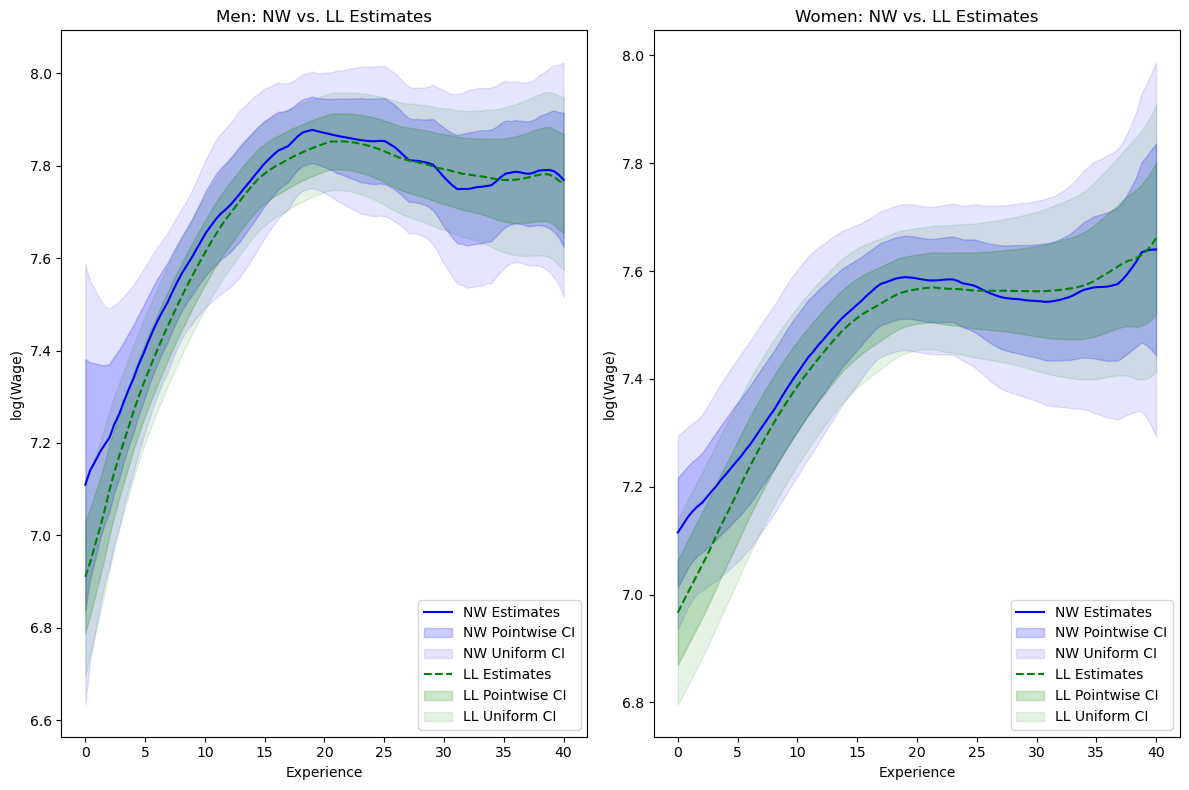

In [19]:
plt.figure(figsize=(12, 8))

for i, (gender, comp_res) in enumerate(comparison_results.items(), 1):
    plt.subplot(1, 2, i)
    
    # Plot NW estimates
    plt.plot(x_grid[gender], comp_res['NW']['m_hat'], label='NW Estimates', color='blue')
    plt.fill_between(x_grid[gender], comp_res['NW']['lower_bounds'], comp_res['NW']['upper_bounds'], 
                     color='blue', alpha=0.2, label='NW Pointwise CI')
    plt.fill_between(x_grid[gender], comp_res['NW']['lower_bound_u'], comp_res['NW']['upper_bound_u'], 
                     color='blue', alpha=0.1, label='NW Uniform CI')
    
    # Plot LL estimates
    plt.plot(x_grid[gender], comp_res['LL']['m_hat'], label='LL Estimates', color='green', linestyle='dashed')
    plt.fill_between(x_grid[gender], comp_res['LL']['lower_bounds'], comp_res['LL']['upper_bounds'], 
                     color='green', alpha=0.2, label='LL Pointwise CI')
    plt.fill_between(x_grid[gender], comp_res['LL']['lower_bound_u'], comp_res['LL']['upper_bound_u'], 
                     color='green', alpha=0.1, label='LL Uniform CI')
    
    # Plot settings
    plt.title(f'{gender}: NW vs. LL Estimates')
    plt.xlabel('Experience')
    plt.ylabel('log(Wage)')
    plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


The Local Linear (LL) estimator provides smoother estimates than the Nadaraya-Watson (NW) estimator, which is more sensitive to local fluctuations and prone to overfitting. LL’s narrower confidence intervals indicate more stable and precise estimates, while NW intervals are wider in regions with sparse data.

Despite these differences, both estimators show the same trend: wages increase with experience up to 20 years, after which they plateau. This consistency underscores the diminishing returns to experience and aligns with economic theories of wage growth.

## 2.
Suppose we assume a linear relationship between the gdp growth and the debt/gdp ratio. Run a least squared (LS) estimation (with a inter- cept term). What is your conclusion from the LS estimation?

In [20]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load the dataset (Assume the dataset is already loaded into a DataFrame named `rr2010`)
# Columns assumed: 'gdp_growth', 'inflation_rate', 'debt_gdp_ratio'
#Lets read the excel RR2010.xlsx
rr2010 = pd.read_excel("RR2010.xlsx")
#Lets put year as index
rr2010 = rr2010.set_index('year')
# Define the variables
X = rr2010['debt']
Y = rr2010['gdp']


In [21]:

# Add an intercept to the independent variable for LS estimation
X_with_intercept = sm.add_constant(X)

# Run OLS regression
ols_model = sm.OLS(Y, X_with_intercept).fit()

# Display the summary
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.927
Date:                Thu, 21 Nov 2024   Prob (F-statistic):              0.167
Time:                        13:47:55   Log-Likelihood:                -634.13
No. Observations:                 219   AIC:                             1272.
Df Residuals:                     217   BIC:                             1279.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3180      0.449      9.610      0.0

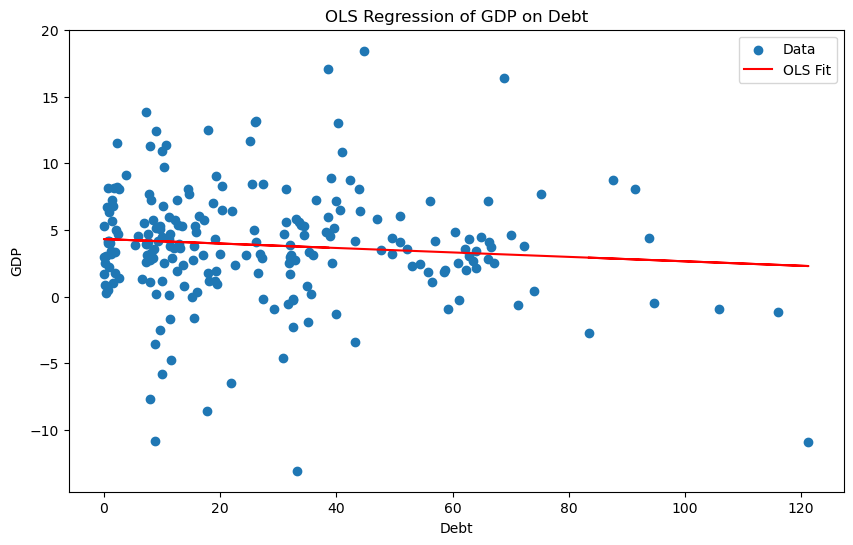

In [22]:
#Lets plot the data and the OLS regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, label='Data')
plt.plot(X, ols_model.predict(X_with_intercept), color='red', label='OLS Fit')
plt.xlabel('Debt')
plt.ylabel('GDP')
#Add the title
plt.title('OLS Regression of GDP on Debt')
plt.legend()
plt.show()


There seems to be a negative relationship between debt/gdp ratio and gdp growth ratio, but not significant. The R-squared is very low, which means that the debt/gdp ratio can only explain a small portion of the gdp growth ratio variation.

## B 
Use Nadaraya-Watson to estimate the regression of gdp growth on the debt ratio. Plot with 95% confidence intervals. (Search the optimal bandwidth over [5; 25])

In [23]:
# Define the range of bandwidths
bandwidth_range = np.linspace(5, 25, 50)

x_grid = np.linspace(X.min(), X.max(), num=100)

In [24]:

# Optimal bandwidths
optimal_bandwidth_nw,nw_residuals = loocv_bandwidth(X.values, Y.values, bandwidth_range, kernel='epanechnikov', estimator='nadaraya_watson')
optimal_bandwidth_ll,ll_residuals = loocv_bandwidth(X.values, Y.values, bandwidth_range, kernel='epanechnikov', estimator='local_linear')
print(optimal_bandwidth_nw)
print(optimal_bandwidth_ll)
# Estimates
nw_estimates = nadaraya_watson(X, Y, x_grid, optimal_bandwidth_nw, kernel='epanechnikov')
ll_intercepts = []
ll_slopes = []
for x in x_grid:
    intercept, slope = local_linear_estimator(X, Y, x, optimal_bandwidth_ll, kernel='epanechnikov')
    ll_intercepts.append(intercept)
    ll_slopes.append(slope)

results['Men'] = {
    'optimal_bandwidth_nw': optimal_bandwidth_nw,
    'optimal_bandwidth_ll': optimal_bandwidth_ll,
    'nw_estimates': nw_estimates,
    'll_intercepts': ll_intercepts,
    'll_slopes': ll_slopes,
    'nw_residuals': nw_residuals,
    'll_residuals': ll_residuals
}

13.16326530612245
16.836734693877553


In [25]:
import scipy.stats as stats


def pointwise_confidence_interval(results,x_grid, kernel, alpha=0.05,gender='Men',estimator = "nadaraya_watson",X=X):
    
    
    if estimator == "nadaraya_watson":
        res_type = "nw_residuals"
        estimate = 'nw_estimates'
        bandwidth = results[gender]['optimal_bandwidth_nw']
    else:
        res_type = 'll_residuals'
        estimate = 'll_intercepts'
        bandwidth = results[gender]['optimal_bandwidth_ll']
    group = X
    X = group.values
    # Compute residuals
    residuals = results[gender][res_type]
    m_hat = results[gender][estimate]
    # Compute s_hat(x)
      # Compute confidence intervals for each x in x_grid
    lower_bounds = []
    upper_bounds = []
    s_hat_1 = []
    for x_eval, m_eval in zip(x_grid, m_hat):
        s_hat = compute_s_hat(X, residuals, x_eval, bandwidth, kernel)
        z = stats.norm.ppf(1 - alpha / 2)
        s_hat_1.append(s_hat)
        lower_bounds.append(m_eval - z * s_hat)
        upper_bounds.append(m_eval + z * s_hat)
    
    return np.array(lower_bounds), np.array(upper_bounds),np.array(s_hat_1)


In [26]:

# Store results for Men and Women
confidence_results = {}
gender = 'Men'
group = X
bandwidth = results[gender]['optimal_bandwidth_nw']
m_hat = results[gender]['nw_estimates']
residuals = results[gender]['nw_residuals']

# Pointwise confidence intervals
lower_bounds, upper_bounds, s_hat_values = pointwise_confidence_interval(
    results=results,
    x_grid=x_grid,
    kernel='epanechnikov',
    gender=gender,
    estimator='nadaraya_watson',
    X=X
)

# Uniform confidence intervals
lower_bound_u, upper_bound_u = uniform_confidence_band(
    x_grid=x_grid,
    X=X,
    m_hat=m_hat,
    residuals=residuals,
    s_hat=s_hat_values,
    bandwidth=bandwidth,
    kernel='epanechnikov',
    B=1000,
    alpha=0.05
)

# Store results
confidence_results[gender] = {
    'm_hat': m_hat,
    'lower_bounds': lower_bounds,
    'upper_bounds': upper_bounds,
    'lower_bound_u': lower_bound_u,
    'upper_bound_u': upper_bound_u
}



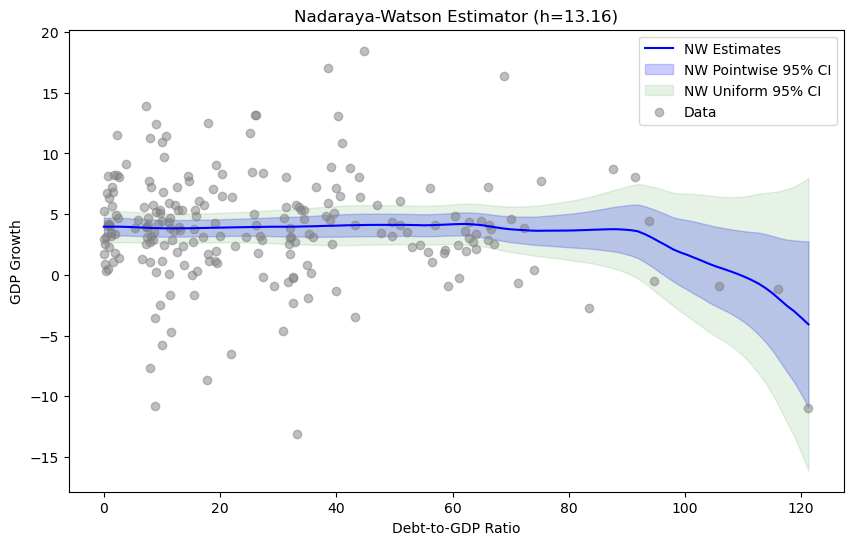

In [27]:

# Plot Nadaraya-Watson Estimates
plt.figure(figsize=(10, 6))
plt.plot(x_grid, nw_estimates, label='NW Estimates', color='blue')
plt.fill_between(x_grid, lower_bounds, upper_bounds, color='blue', alpha=0.2, label='NW Pointwise 95% CI')
plt.fill_between(x_grid, lower_bound_u, upper_bound_u, 
                     color='green', alpha=0.1, label='NW Uniform 95% CI')
plt.scatter(X, Y, color='gray', alpha=0.5, label='Data')
plt.title(f'Nadaraya-Watson Estimator (h={optimal_bandwidth_nw:.2f})')
plt.xlabel('Debt-to-GDP Ratio')
plt.ylabel('GDP Growth')
plt.legend()
plt.show()

## B.
Repeat using the Local Linear estimator. (Search the optimal band- width over [5; 25])

In [29]:

# Store results for Men and Women
confidence_results = {}
gender = 'Men'
group = X
bandwidth = results[gender]['optimal_bandwidth_ll']
m_hat = results[gender]['ll_intercepts']
residuals = results[gender]['ll_residuals']

# Pointwise confidence intervals
lower_bounds, upper_bounds, s_hat_values = pointwise_confidence_interval(
    results=results,
    x_grid=x_grid,
    kernel='epanechnikov',
    gender=gender,
    estimator='nadaraya_watson',
    X=X
)

# Uniform confidence intervals
lower_bound_u, upper_bound_u = uniform_confidence_band(
    x_grid=x_grid,
    X=X,
    m_hat=m_hat,
    residuals=residuals,
    s_hat=s_hat_values,
    bandwidth=bandwidth,
    kernel='epanechnikov',
    B=1000,
    alpha=0.05
)

# Store results
confidence_results[gender] = {
    'm_hat': m_hat,
    'lower_bounds': lower_bounds,
    'upper_bounds': upper_bounds,
    'lower_bound_u': lower_bound_u,
    'upper_bound_u': upper_bound_u
}



In [30]:
def calculate_estimates(X, Y, x_grid, bandwidth, estimator, kernel='epanechnikov'):
    if estimator == 'nadaraya_watson':
        return nadaraya_watson(X, Y, x_grid, bandwidth, kernel)
    elif estimator == 'local_linear':
        estimates = []
        for x in x_grid:
            intercept, _ = local_linear_estimator(X, Y, x, bandwidth, kernel)
            estimates.append(intercept)
        return np.array(estimates)
    else:
        raise ValueError("Unsupported estimator")

def compute_confidence_intervals(X, Y, x_grid, residuals, estimates, bandwidth, kernel, alpha=0.05, B=1000):
    # Pointwise confidence intervals
    lower_bounds, upper_bounds, s_hat_values = [], [], []
    z = stats.norm.ppf(1 - alpha / 2)

    for x_eval, m_eval in zip(x_grid, estimates):
        s_hat = compute_s_hat(X, residuals, x_eval, bandwidth, kernel)
        lower_bounds.append(m_eval - z * s_hat)
        upper_bounds.append(m_eval + z * s_hat)
        s_hat_values.append(s_hat)
    
    # Convert s_hat_values to a NumPy array
    s_hat_values = np.array(s_hat_values)
    
    # Uniform confidence intervals
    lower_bound_u, upper_bound_u = uniform_confidence_band(
        x_grid=x_grid,
        X=X,
        m_hat=estimates,
        residuals=residuals,
        s_hat=s_hat_values,
        bandwidth=bandwidth,
        kernel=kernel,
        B=B,
        alpha=alpha
    )
    
    return (np.array(lower_bounds), np.array(upper_bounds), 
            lower_bound_u, upper_bound_u, s_hat_values)



In [31]:
# Define the range of bandwidths and grid
bandwidth_range = np.linspace(5, 25, 50)
x_grid = np.linspace(X.min(), X.max(), 100)

# Compute optimal bandwidths
optimal_bandwidth_nw, nw_residuals = loocv_bandwidth(
    X.values, Y.values, bandwidth_range, kernel='epanechnikov', estimator='nadaraya_watson'
)
optimal_bandwidth_ll, ll_residuals = loocv_bandwidth(
    X.values, Y.values, bandwidth_range, kernel='epanechnikov', estimator='local_linear'
)

# Compute estimates for NW and LL
nw_estimates = calculate_estimates(X, Y, x_grid, optimal_bandwidth_nw, estimator='nadaraya_watson')
ll_estimates = calculate_estimates(X, Y, x_grid, optimal_bandwidth_ll, estimator='local_linear')

# Compute confidence intervals for NW
nw_lower_bounds, nw_upper_bounds, nw_lower_bound_u, nw_upper_bound_u, nw_s_hat = compute_confidence_intervals(
    X=X.values, Y=Y.values, x_grid=x_grid, residuals=nw_residuals, 
    estimates=nw_estimates, bandwidth=optimal_bandwidth_nw, kernel='epanechnikov'
)

# Compute confidence intervals for LL
ll_lower_bounds, ll_upper_bounds, ll_lower_bound_u, ll_upper_bound_u, ll_s_hat = compute_confidence_intervals(
    X=X.values, Y=Y.values, x_grid=x_grid, residuals=ll_residuals, 
    estimates=ll_estimates, bandwidth=optimal_bandwidth_ll, kernel='epanechnikov'
)

# Store results for easier access
results = {
    'nadaraya_watson': {
        'estimates': nw_estimates,
        'lower_bounds': nw_lower_bounds,
        'upper_bounds': nw_upper_bounds,
        'lower_bound_u': nw_lower_bound_u,
        'upper_bound_u': nw_upper_bound_u,
        'bandwidth': optimal_bandwidth_nw
    },
    'local_linear': {
        'estimates': ll_estimates,
        'lower_bounds': ll_lower_bounds,
        'upper_bounds': ll_upper_bounds,
        'lower_bound_u': ll_lower_bound_u,
        'upper_bound_u': ll_upper_bound_u,
        'bandwidth': optimal_bandwidth_ll
    }
}


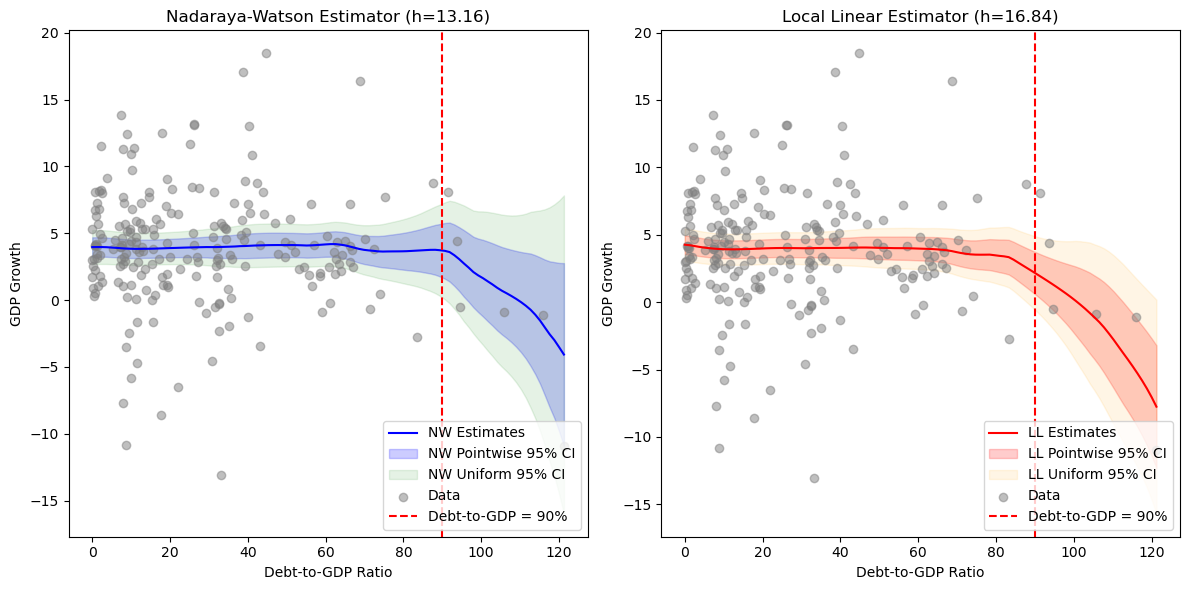

In [32]:
plt.figure(figsize=(12, 6))

# Plot Nadaraya-Watson Estimator
plt.subplot(1, 2, 1)
plt.plot(x_grid, nw_estimates, label='NW Estimates', color='blue')
plt.fill_between(x_grid, nw_lower_bounds, nw_upper_bounds, color='blue', alpha=0.2, label='NW Pointwise 95% CI')
plt.fill_between(x_grid, nw_lower_bound_u, nw_upper_bound_u, color='green', alpha=0.1, label='NW Uniform 95% CI')
plt.scatter(X, Y, color='gray', alpha=0.5, label='Data')
plt.axvline(x=90, color='red', linestyle='--', label='Debt-to-GDP = 90%')
plt.title(f'Nadaraya-Watson Estimator (h={optimal_bandwidth_nw:.2f})')
plt.xlabel('Debt-to-GDP Ratio')
plt.ylabel('GDP Growth')
plt.legend(loc='lower right')

# Plot Local Linear Estimator
plt.subplot(1, 2, 2)
plt.plot(x_grid, ll_estimates, label='LL Estimates', color='red')
plt.fill_between(x_grid, ll_lower_bounds, ll_upper_bounds, color='red', alpha=0.2, label='LL Pointwise 95% CI')
plt.fill_between(x_grid, ll_lower_bound_u, ll_upper_bound_u, color='orange', alpha=0.1, label='LL Uniform 95% CI')
plt.scatter(X, Y, color='gray', alpha=0.5, label='Data')
plt.axvline(x=90, color='red', linestyle='--', label='Debt-to-GDP = 90%')
plt.title(f'Local Linear Estimator (h={optimal_bandwidth_ll:.2f})')
plt.xlabel('Debt-to-GDP Ratio')
plt.ylabel('GDP Growth')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


## C 
Do you see evidence of nonlinearity and/or a change in the relationship at 90%?

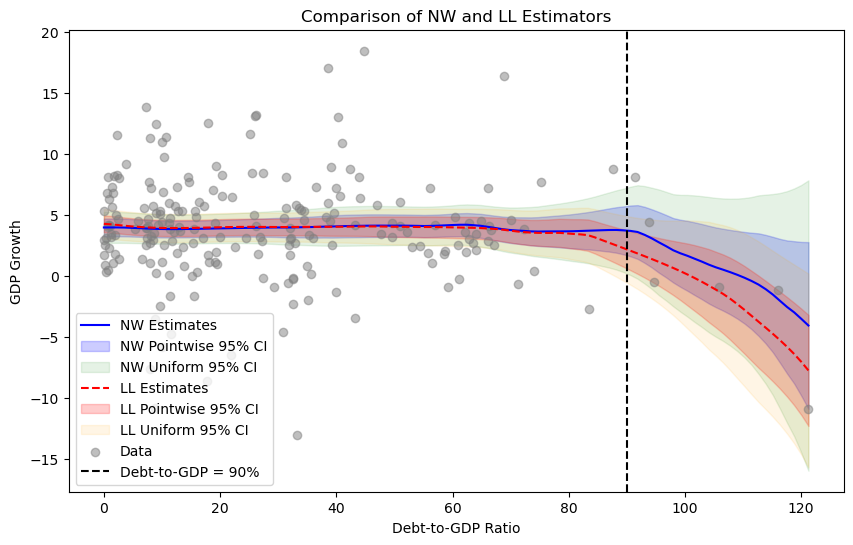

In [33]:
plt.figure(figsize=(10, 6))

# Plot NW Estimates and Confidence Intervals
plt.plot(x_grid, nw_estimates, label='NW Estimates', color='blue', linestyle='solid')
plt.fill_between(x_grid, nw_lower_bounds, nw_upper_bounds, color='blue', alpha=0.2, label='NW Pointwise 95% CI')
plt.fill_between(x_grid, nw_lower_bound_u, nw_upper_bound_u, color='green', alpha=0.1, label='NW Uniform 95% CI')

# Plot LL Estimates and Confidence Intervals
plt.plot(x_grid, ll_estimates, label='LL Estimates', color='red', linestyle='dashed')
plt.fill_between(x_grid, ll_lower_bounds, ll_upper_bounds, color='red', alpha=0.2, label='LL Pointwise 95% CI')
plt.fill_between(x_grid, ll_lower_bound_u, ll_upper_bound_u, color='orange', alpha=0.1, label='LL Uniform 95% CI')

# Scatter plot for data
plt.scatter(X, Y, color='gray', alpha=0.5, label='Data')

# Highlight debt-to-GDP = 90% threshold
plt.axvline(x=90, color='black', linestyle='--', label='Debt-to-GDP = 90%')

plt.title('Comparison of NW and LL Estimators')
plt.xlabel('Debt-to-GDP Ratio')
plt.ylabel('GDP Growth')
plt.legend(loc='lower left')
plt.show()


The plot shows evidence of nonlinearity, especially for debt-to-GDP ratios above 90%. Below 90%, GDP growth is relatively flat, but above 90%, there’s a noticeable downward trend, more pronounced with the NW estimator.

The wider confidence intervals for the NW estimator reflect its flexibility as it makes no assumptions about the relationship, relying purely on data density. This makes it more sensitive to noise and variability, especially in regions with sparse data. In contrast, the LL estimator assumes a local linear structure, resulting in smoother estimates and narrower confidence intervals by reducing the influence of outliers.

This difference shows the NW estimator is more cautious and better at capturing potential nonlinearities, while the LL estimator provides more stable estimates. Both suggest a shift in the relationship above the 90% debt-to-GDP threshold, supporting Reinhart and Rogoff’s claim.